### Load and inspect the data

In [30]:
import pandas as pd
import numpy as np  
import geopandas as gpd

import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim

In [31]:
csv_data = pd.read_csv('dataset/alles_20171819_3tracties.csv', delimiter=';')
print(csv_data.head())
print(csv_data.isnull().sum())
print(csv_data.dtypes)
print(csv_data.describe())

C:\Users\postv\AppData\Local\Temp\ipykernel_4424\2455432584.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_data = pd.read_csv('dataset/alles_20171819_3tracties.csv', delimiter=';')


                   ID  tractie maand       datum              tijdstip   
0  427120170501070012     4271   mei  2017-05-01  2017-05-01T07:00:12Z  \
1  427120170501070017     4271   mei  2017-05-01  2017-05-01T07:00:17Z   
2  427120170501070018     4271   mei  2017-05-01  2017-05-01T07:00:18Z   
3  427120170501070019     4271   mei  2017-05-01  2017-05-01T07:00:19Z   
4  427120170501070020     4271   mei  2017-05-01  2017-05-01T07:00:20Z   

    actie       lat     long  seconde UTRGRID100  
0  Rijden  52,10771  5,07925        1  1339_4577  
1  Rijden  52,10771  5,07926        1  1339_4577  
2  Rijden  52,10771  5,07928        1  1339_4577  
3  Rijden  52,10771  5,07930        1  1339_4577  
4  Rijden  52,10771  5,07932        1  1339_4577  
ID            0
tractie       0
maand         0
datum         0
tijdstip      0
actie         0
lat           0
long          0
seconde       0
UTRGRID100    0
dtype: int64
ID            object
tractie        int64
maand         object
datum        

In [32]:
grid_data = gpd.read_file("dataset/UTRGRID100/UTRGRID100WGS84.shp")
grid_data = grid_data.to_crs(epsg=4326)
print(grid_data.head())
print(grid_data.columns)
print(grid_data.crs)

        ID  Geometry_A  Geometry_P UTRGRID100      XCEN      XMAX      XMIN   
0  11186.0     10000.0       400.0  1289_4559  128950.0  129000.0  128900.0  \
1  16061.0     10000.0       400.0  1359_4590  135950.0  136000.0  135900.0   
2     61.0     10000.0       400.0  1324_4487  132450.0  132500.0  132400.0   
3  11187.0     10000.0       400.0  1290_4559  129050.0  129100.0  129000.0   
4  16062.0     10000.0       400.0  1360_4590  136050.0  136100.0  136000.0   

       YCEN      YMAX      YMIN   
0  455950.0  456000.0  455900.0  \
1  459050.0  459100.0  459000.0   
2  448750.0  448800.0  448700.0   
3  455950.0  456000.0  455900.0   
4  459050.0  459100.0  459000.0   

                                            geometry  
0  POLYGON ((5.00636 52.09074, 5.00636 52.09164, ...  
1  POLYGON ((5.10833 52.11889, 5.10832 52.11979, ...  
2  POLYGON ((5.05791 52.02618, 5.0579 52.02708, 5...  
3  POLYGON ((5.00782 52.09075, 5.00781 52.09165, ...  
4  POLYGON ((5.10979 52.11889, 5.10978 

### Feature engineering for all models and summary of model requirements
 - aggregate data bygrid and date. We need the total sweeping time per grid per day. 
 - include some lagged features for regression / rnn to be useful
 - add rolling averages
 - add Temporal features like day, week, month
 - add categorical features for xgb 


 1. Regression model
    - Target: seconde (continuous variable).
    - Features: Use all lagged, rolling, and temporal features.
 2. RNN
    - Group the dataset by UTRGRID100 and create sequences of input-output pairs:
    - Input: Lagged and rolling features.
    - Output: seconde (future sweeping effort).
 3.
    - Features: Lagged, rolling, and temporal features.
    - Target: hotspot_category.


In [33]:

csv_data['tijdstip'] = pd.to_datetime(csv_data['tijdstip'])
csv_data['datum'] = pd.to_datetime(csv_data['datum'])

# filter for arbeid and grid/date
arbeid_data = csv_data[csv_data['actie'] == 'Arbeid']
aggregated_data = arbeid_data.groupby(['datum', 'UTRGRID100']).agg({
    'seconde': 'sum'
}).reset_index()

# lagged features
aggregated_data['lagged_seconde_1'] = aggregated_data.groupby('UTRGRID100')['seconde'].shift(1)
aggregated_data['lagged_seconde_2'] = aggregated_data.groupby('UTRGRID100')['seconde'].shift(2)

# rolling average
aggregated_data['rolling_mean_seconde_3'] = aggregated_data.groupby('UTRGRID100')['seconde'] \
    .rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
aggregated_data['rolling_mean_seconde_5'] = aggregated_data.groupby('UTRGRID100')['seconde'] \
    .rolling(window=5, min_periods=1).mean().reset_index(0, drop=True)
# temporal features
aggregated_data['day_of_week'] = aggregated_data['datum'].dt.weekday
aggregated_data['month'] = aggregated_data['datum'].dt.month
aggregated_data['week_of_year'] = aggregated_data['datum'].dt.isocalendar().week

# hotspot category
aggregated_data['hotspot_category'] = pd.cut(
    aggregated_data['seconde'] / 60,
    bins=[0, 5, 10, 15, float('inf')],
    labels=["<5 min", "5-10 min", "10-15 min", "15+ min"]
)

aggregated_data['lagged_seconde_1'].fillna(0, inplace=True)
aggregated_data['lagged_seconde_2'].fillna(0, inplace=True)

# merging the shapefiles with the adjusted features
# doing this before due to computational resources
# although could try do it after since some spatial relationships are lost
data = grid_data.merge(aggregated_data, on='UTRGRID100', how='inner')


In [34]:
print(data.head())
print(aggregated_data.isnull().sum())
print(aggregated_data.describe())


        ID  Geometry_A  Geometry_P UTRGRID100      XCEN      XMAX      XMIN   
0  10928.0     10000.0       400.0  1341_4557  134150.0  134200.0  134100.0  \
1  10928.0     10000.0       400.0  1341_4557  134150.0  134200.0  134100.0   
2  11083.0     10000.0       400.0  1341_4558  134150.0  134200.0  134100.0   
3  10788.0     10000.0       400.0  1356_4556  135650.0  135700.0  135600.0   
4  10789.0     10000.0       400.0  1357_4556  135750.0  135800.0  135700.0   

       YCEN      YMAX      YMIN  ...      datum seconde  lagged_seconde_1   
0  455750.0  455800.0  455700.0  ... 2017-05-18       4               0.0  \
1  455750.0  455800.0  455700.0  ... 2018-07-06       2               4.0   
2  455850.0  455900.0  455800.0  ... 2018-10-19       4               0.0   
3  455650.0  455700.0  455600.0  ... 2019-04-10      23               0.0   
4  455650.0  455700.0  455600.0  ... 2019-04-10      68               0.0   

   lagged_seconde_2  rolling_mean_seconde_3  rolling_mean_seco

### Categorical XGBoost
Input features:
 - Lagged features 
 - Rolling averages
 - Temporal features
 - Categorical features

Output features:
 - Hotspot category (4 categories)
    - <5 min
    - 5-10 min
    - 10-15 min
    - 15+ min

Class Weights: {0: 0.2860572042753926, 1: 2.740931456688408, 2: 11.213951310861423, 3: 19.927620632279535}


c:\Users\postv\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     20934
           1       0.94      0.94      0.94      2185
           2       0.88      0.84      0.86       534
           3       0.86      0.90      0.88       300

    accuracy                           0.99     23953
   macro avg       0.92      0.92      0.92     23953
weighted avg       0.99      0.99      0.99     23953

Accuracy: 0.9854
Balanced Accuracy: 0.9188


c:\Users\postv\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\postv\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\postv\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [16:48:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are no

Cross-validation scores: [0.9854298  0.98509581 0.98509581 0.98355112 0.98492882]
Mean CV Accuracy: 0.9848 ± 0.0007


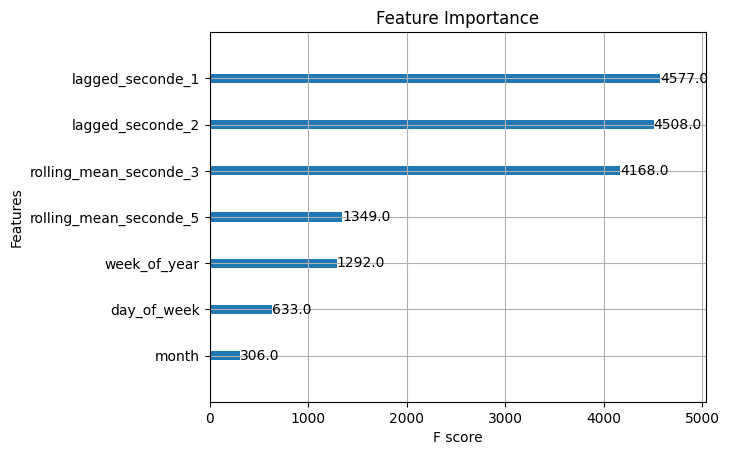

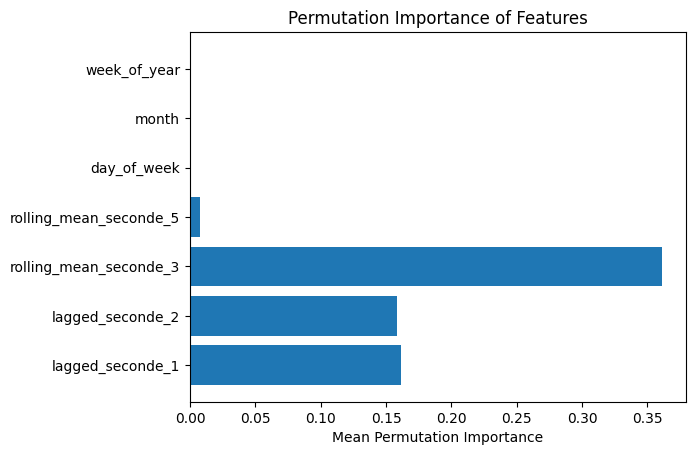

c:\Users\postv\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\postv\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\postv\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [16:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are no

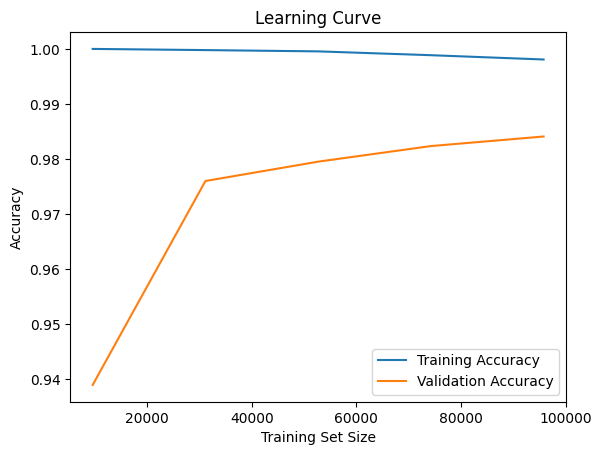

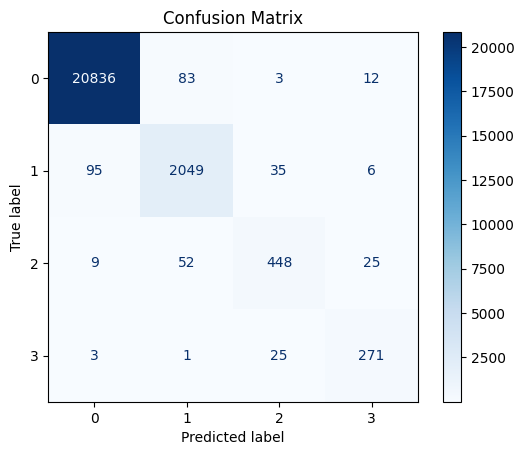

Training Accuracy: 0.9980
Test Accuracy: 0.9854
Mean CV Accuracy: 0.9848 ± 0.0007


In [35]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

features = [
    'lagged_seconde_1', 
    'lagged_seconde_2',
    'rolling_mean_seconde_3', 
    'rolling_mean_seconde_5',
    'day_of_week', 
    'month', 
    'week_of_year'
]
target = 'hotspot_category'
data[target] = data[target].astype('category').cat.codes

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

class_weights = {i: len(y_train) / (len(y_train.unique()) * count) 
                 for i, count in y_train.value_counts().items()}
print("Class Weights:", class_weights)

model = xgb.XGBClassifier(
    eval_metric='mlogloss',  
    use_label_encoder=False, 
    random_state=42,
    scale_pos_weight=[class_weights[i] for i in range(len(class_weights))]
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=skf, scoring="accuracy")

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

xgb.plot_importance(model, importance_type='weight', title="Feature Importance")
plt.show()

perm_importance = permutation_importance(model, X_test, y_test, scoring="accuracy", random_state=42)
plt.barh(features, perm_importance.importances_mean)
plt.xlabel("Mean Permutation Importance")
plt.title("Permutation Importance of Features")
plt.show()

train_sizes, train_scores, valid_scores = learning_curve(
    model, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=5, scoring="accuracy"
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Training Accuracy")
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")



In [40]:
print(data[data['datum'] >= cutoff_date].head())
print(data[data['datum'] < cutoff_date].tail())
overlap = pd.merge(train_data, test_data, how='inner', on=features)
print(f"Overlap between train and test: {len(overlap)} rows")
overlap = pd.merge(train_data, test_data, how='inner', on=features)

num_overlap = len(overlap)
print(f"Number of overlapping rows: {num_overlap}")
test_size = len(test_data)
leakage_percentage = (num_overlap / test_size) * 100
print(f"Data leakage as a percentage of the test set: {leakage_percentage:.2f}%")
print(f"Original train size: {len(train_data)}")
print(f"Original test size: {len(test_data)}")


         ID  Geometry_A  Geometry_P UTRGRID100      XCEN      XMAX      XMIN   
3   10788.0     10000.0       400.0  1356_4556  135650.0  135700.0  135600.0  \
4   10789.0     10000.0       400.0  1357_4556  135750.0  135800.0  135700.0   
8   10944.0     10000.0       400.0  1357_4557  135750.0  135800.0  135700.0   
13  11110.0     10000.0       400.0  1368_4558  136850.0  136900.0  136800.0   
14  10645.0     10000.0       400.0  1368_4555  136850.0  136900.0  136800.0   

        YCEN      YMAX      YMIN  ...      datum seconde  lagged_seconde_1   
3   455650.0  455700.0  455600.0  ... 2019-04-10      23               0.0  \
4   455650.0  455700.0  455600.0  ... 2019-04-10      68               0.0   
8   455750.0  455800.0  455700.0  ... 2019-04-10      39               0.0   
13  455850.0  455900.0  455800.0  ... 2019-10-21       1             624.0   
14  455550.0  455600.0  455500.0  ... 2019-10-21       1               0.0   

    lagged_seconde_2  rolling_mean_seconde_3  roll

In [14]:
def predict_daily_hotspots(data, model, features, grid_data):
    daily_predictions = []
    unique_dates = data['datum'].unique()
    data['center_longitude'] = data['geometry'].centroid.x
    
    data['center_latitude'] = data['geometry'].centroid.y
    category_labels = ["<5 min", "5-10 min", "10-15 min", "15+ min"]
    
    for date in unique_dates:
        date_data = data[data['datum'] == date].copy()
        X_date = date_data[features]
        predictions = model.predict(X_date)
        output_df = date_data.copy()
        output_df['hotspot_category'] = [category_labels[pred] for pred in predictions]
        output_df['predicted_seconds'] = output_df['seconde']
        daily_predictions.append(output_df)
    
    final_predictions = pd.concat(daily_predictions)
    
    output_columns = ['UTRGRID100', 'datum', 'hotspot_category', 'predicted_seconds', 
                  'center_longitude', 'center_latitude', 'geometry']
    final_predictions = final_predictions[output_columns]
    
    final_predictions.to_csv('daily_hotspot_predictions.csv', index=False)
    
    print(f"Predictions saved to daily_hotspot_predictions.csv")
    return final_predictions

predictions = predict_daily_hotspots(data, model, features, grid_data)

C:\Users\postv\AppData\Local\Temp\ipykernel_4424\3804097359.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data['center_longitude'] = data['geometry'].centroid.x
C:\Users\postv\AppData\Local\Temp\ipykernel_4424\3804097359.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data['center_latitude'] = data['geometry'].centroid.y


Predictions saved to daily_hotspot_predictions.csv


### Random forest regression
Input features:
 - Lagged features 
 - Rolling averages
 - Temporal features

Output features:
 - Seconde (continuous)
    - Total sweeping time (in seconds) for a specific grid (UTRGRID100) on a given day (datum).

In [15]:
features = [
    'lagged_seconde_1', 
    'lagged_seconde_2',
    'rolling_mean_seconde_3', 
    'rolling_mean_seconde_5',
    'day_of_week', 
    'month', 
    'week_of_year'
]
target = 'seconde'

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# train model
model = RandomForestRegressor(
    n_estimators = 100,
    random_state = 42,
    n_jobs = -1
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 5.4878123825825575
Mean Squared Error (MSE): 653.2276296956541
Root Mean Squared Error (RMSE): 25.558318209452946
R² Score: 0.9834148857972359


### Recurrent neural network (RNN)
Due to the sequential nature of the data i will as an attempt to exploration implement LSTM layers inside this RNN.
Input features:
 - Lagged features 
 - Rolling averages
 - Temporal features

Output features:
 - Seconde (continuous)
    - Total sweeping time (in seconds) for a specific grid (UTRGRID100) on a given day (datum).

Architecture:
 - Input: A sequence of feature vectors that includes lagged, rolling, and temporal data for each grid and day.
 - LSTM Layer: Captures the dependencies and patterns in the time-series data.
 - Fully Connected Layer: Converts the LSTM outputs into a predicted value.
 - Output: The model outputs the predicted sweeping time (seconde), a continuous value representing the effort required for a grid on a given day.




In [65]:
features = [
    'lagged_seconde_1', 
    'lagged_seconde_2',
    'rolling_mean_seconde_3', 
    'rolling_mean_seconde_5',
    'day_of_week', 
    'month', 
    'week_of_year'
]
target = 'seconde'


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data[features])

# applying log transformation to the target to make the distribution more manageable
# this makes the variance more stable
data[target] = np.log1p(data[target])

# create lstm sequences
# they determine what days are taken with the input of the lstm
# memory of 3 days is tested
def create_sequences(X, y, seq_length=20):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, data[target].values)

# train test split with tensors
X_seq_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_seq_tensor = torch.tensor(y_seq, dtype=torch.float32)
X_train, X_test, y_train, y_test = train_test_split(X_seq_tensor, y_seq_tensor, test_size=0.2, random_state=42)

# bidirectional lstm model for testing
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)  # BiLSTM
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 because of bidirectional

    def forward(self, x):
        lstm_out, (hn, cn) = self.bilstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Using the last hidden state for output
        return out

# initialize model further
input_size = X_train.shape[2]  
hidden_size = 32  
output_size = 1  
model = LSTM(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.SmoothL1Loss()

# train model
epochs = 100 
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(X_train)
    loss = criterion(y_pred.squeeze(), y_train)
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

# evaluate model
model.eval()
with torch.no_grad():
    
    y_pred = model(X_test)
    y_pred = np.expm1(y_pred.numpy()) 
    
    y_test = np.expm1(y_test.numpy())

# calculate metrics

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Epoch [5/100], Loss: 3.8209400177001953
Epoch [10/100], Loss: 3.7591395378112793
Epoch [15/100], Loss: 3.692800283432007
Epoch [20/100], Loss: 3.6150896549224854
Epoch [25/100], Loss: 3.5124378204345703
Epoch [30/100], Loss: 3.3558759689331055
Epoch [35/100], Loss: 3.0915231704711914
Epoch [40/100], Loss: 2.703521728515625
Epoch [45/100], Loss: 2.2903547286987305
Epoch [50/100], Loss: 1.9132368564605713
Epoch [55/100], Loss: 1.5695843696594238
Epoch [60/100], Loss: 1.2581634521484375
Epoch [65/100], Loss: 0.9945753812789917
Epoch [70/100], Loss: 0.7917879223823547
Epoch [75/100], Loss: 0.6548727750778198
Epoch [80/100], Loss: 0.5799463987350464
Epoch [85/100], Loss: 0.5511438250541687
Epoch [90/100], Loss: 0.5470896363258362
Epoch [95/100], Loss: 0.5506176948547363
Epoch [100/100], Loss: 0.5529188513755798
Mean Absolute Error (MAE): 110.6532211303711
Mean Squared Error (MSE): 42800.203125
Root Mean Squared Error (RMSE): 206.88209533691406
R² Score: -0.045228204404368144
